In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score, accuracy_score, \
balanced_accuracy_score, confusion_matrix, roc_curve, auc, \
precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer

import copy
import warnings 
import os 
import random
warnings.filterwarnings("ignore")

import umap
from numpy import linalg as LA
from helper import *
from npr import *

In [2]:
NPR_REG = True
NUM_CLASS, CLUSTER, EMBED = 8, 4, 1280
LAMBDA_ = 5e-2
PERSONALIZED = True

if PERSONALIZED:
    head = ['classifier.1.weight','classifier.1.bias']
else:
    head = []

BATCH_SIZE = 64
NUM_WORKERS = 8

epochs = 80
lr, momentum, wd = 1e-3, 0.9, 5e-4
epochs_lr_decay  = [60, 70]
lr_decay = 0.1
device = torch.device('cuda:0')

color_code = ['b','g','r','c','m','y','k']

## select experiment setting

In [3]:
PTH = '../datasets/isic/'
PTH_gt = PTH +  'ISIC_2019_Training_GroundTruth.csv'
PTH_metadata = PTH + 'ISIC_2019_Training_Metadata.csv'
PTH_DATA = PTH + 'isic2019_processed/'
PTH_split = '[isic]train_test_split'
train_split = pd.read_csv(PTH_split)

CLIENTS = ['BCN', 'vidir_molemax', 'vidir_modern', 'rosendahl', 'MSK4', 'vienna_dias']
TOTAL_CLIENTS = len(CLIENTS)

## load the data

In [4]:
split_per_center = dict()
train_data = dict()
test_data = dict()


global_train_img = []
global_train_lbl = []
global_test_img = []
global_test_lbl = []
for i in range(6):
    split_per_center[i] = train_split[train_split['center'] == i]
    lbl_ = split_per_center[i]['target']
    
    ## get the train and test split
    train_idx = [True if f.split('_')[0]=='train' else \
                 False for f in split_per_center[i]['fold2']]
    
    test_idx = [True if f.split('_')[0]=='test' else \
                 False for f in split_per_center[i]['fold2']]

    '''
    testing
    '''
    train_data[CLIENTS[i]] = {"image":np.array([PTH_DATA+fname+'.jpg' for \
                                                    fname in split_per_center[i][train_idx]['image']]),\
                                  "label":np.array([int(lbl) for lbl in lbl_[train_idx]])}

    test_data[CLIENTS[i]] = {"image":np.array([PTH_DATA+fname+'.jpg' for \
                                                    fname in split_per_center[i][test_idx]['image']]),\
                                  "label":np.array([int(lbl) for lbl in lbl_[test_idx]])}

    global_train_img+= [PTH_DATA+fname+'.jpg' for fname in split_per_center[i][train_idx]['image']]
    global_train_lbl+= [int(lbl) for lbl in lbl_[train_idx]]
    
    global_test_img+= [PTH_DATA+fname+'.jpg' for fname in split_per_center[i][test_idx]['image']]
    global_test_lbl+= [int(lbl) for lbl in lbl_[test_idx]]
    
    
    ##################################
    tmp_ = np.array([int(lbl) for lbl in lbl_])
    print('center ', i, ':', np.unique(tmp_,return_counts=True))
    clstype, clsamt = np.unique(tmp_, return_counts=True)
    
    
    print('total data', len(tmp_))
    print('train ratio: , ', np.sum(np.array(train_idx))/len(tmp_))
    print()
    
train_data['global'] = {"image":np.array(global_train_img), "label":np.array(global_train_lbl)}
test_data['global'] = {"image":np.array(global_test_img), "label":np.array(global_test_lbl)}

center  0 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([2857, 4206, 2809,  737, 1138,  124,  111,  431]))
total data 12413
train ratio: ,  0.7999677757190042

center  1 : (array([0, 1, 2, 4, 5, 6]), array([  24, 3720,    2,  124,   30,   54]))
total data 3954
train ratio: ,  0.7999494183105715

center  2 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 680, 1832,  211,   21,  475,   51,   82,   11]))
total data 3363
train ratio: ,  0.800178412132025

center  3 : (array([0, 1, 2, 3, 4, 5, 6, 7]), array([342, 803, 296, 109, 490,  30,   3, 186]))
total data 2259
train ratio: ,  0.7999114652501107

center  4 : (array([0, 1, 4]), array([215, 415, 189]))
total data 819
train ratio: ,  0.7997557997557998

center  5 : (array([0, 1, 2, 4, 5, 6]), array([ 67, 350,   5,  10,   4,   3]))
total data 439
train ratio: ,  0.7995444191343963



## dataloader

In [5]:
#########################
# Class for loading the #
# skin dataset          #
#########################
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]


class cancer(Dataset):
    def __init__(self, im_path, class_label, \
                 transformation=None, num_class=8):
        self.data = im_path
        self.label = class_label
        self.transform = transformation
        self.num_class = num_class
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        image = Image.open(self.data[idx])
        if self.transform: # augmentation
            image = self.transform(image)
        else:
            image = Resize((224,224))(image)
            image = TF.to_tensor(image)
        label = self.label[idx]
        label_onehot = torch.FloatTensor(self.num_class).zero_()
        label_onehot[label] = 1.0
        
        return image, label, idx, label_onehot
    
input_transform_train = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    RandomRotation(degrees=(-10,10)),
    Resize((224,224)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])

input_transform_test = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])


In [6]:
CE_loss = nn.CrossEntropyLoss(reduction='none')
clsnm_, criterions_, loader = dict(), dict(), dict()
_, clsnm_global = np.unique(train_data['global']['label'], return_counts=True)

for cl_name in CLIENTS:
    loader['train_'+cl_name] = DataLoader(cancer(train_data[cl_name]['image'], \
                                               train_data[cl_name]['label'], input_transform_train), \
                                        shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    loader['test_'+cl_name] = DataLoader(cancer(test_data[cl_name]['image'], \
                                               test_data[cl_name]['label'], input_transform_test), \
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    cls, clsnm = np.unique(train_data[cl_name]['label'], return_counts=True)
    clsnm_[cl_name] = np.zeros(NUM_CLASS)
    for idx, i in enumerate(cls):
        clsnm_[cl_name][i] = clsnm[idx]

    criterions_[cl_name] = CustomLoss(clsnm_[cl_name], \
                                      CE_loss,device, balance=True)

# binarize label
label_binarizer = LabelBinarizer().fit(train_data['global']['label'].astype('int'))

avg acc per client, 0.6210072016861712 0.6878915561774458
avg auc now: 0.9128685978762597 avg auc best: 0.9119425093399052


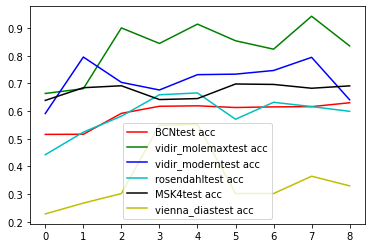

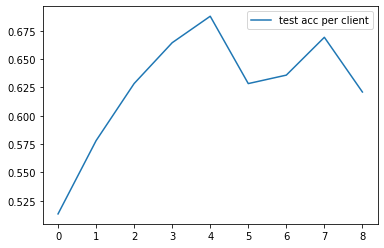

epoch number 9 


In [ ]:
best_avg_acc = 0.0
epoch_best_avg = 0

acc_train, loss_train, acc_test = dict(), dict(), dict() 
nets, optimizers, schedulers = dict(), dict(), dict()
weights = dict()

avg_auc_ = dict()
prototypes_ = dict()

index = [] 
#### additional storage ####
test_acc_avg = []
pc_avg_auc= []
###############################################
### federated model #####
tmp = models.efficientnet_b0(pretrained=True)
tmp.classifier[1] = nn.Linear(in_features=1280, \
                              out_features=NUM_CLASS, bias=True)

nets['global'] = tmp
nets['global'].to(device)
##########################
total = 0
num_client = 0
for key,_ in loader.items():
    if key[:4] == 'test':
        tmp = key[5:]
        acc_train[tmp], loss_train[tmp] = [], []
        acc_test[tmp] = []
        avg_auc_[tmp] = []
        #########################################
        prototypes_[tmp] = npr(cluster=CLUSTER, classnum=NUM_CLASS,\
                         embed=EMBED).to(device)
        weights[tmp] = len(loader['train_'+tmp].dataset)
        total += weights[tmp]
        num_client += 1
        tmp_ = models.efficientnet_b0(pretrained=True)
        tmp_.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASS, bias=True)
        
        nets[tmp] = tmp_
        nets[tmp].to(device)
        optimizers[tmp] = optim.Adam(nets[tmp].parameters(), lr=lr, \
           weight_decay=wd)
        schedulers[tmp] = optim.lr_scheduler.MultiStepLR(optimizers[tmp],
                                                      milestones=epochs_lr_decay,
                                                      gamma=lr_decay)
# assign federated average weight
WEIGHTS_CL = np.zeros(num_client)
for idx, cl_name in enumerate(CLIENTS):
    WEIGHTS_CL[idx] = weights[cl_name]/total * 1.0

for epoch in range(80):
    index.append(epoch) 
    print("epoch number %d " % epoch)
    # aggregate model and download to client
    aggr_fed(CLIENTS, WEIGHTS_CL, nets, fed_name='global', head=[])
    copy_fed(CLIENTS, nets, fed_name='global', head=head)
    
    
    '''
    training
    '''
    for client, _ in acc_train.items():
        update_prototype(loader['train_'+client], nets[client], \
                        prototypes_[client], device)
        criterion = criterions_[client]
        schedulers[client].step() # step
        train(loader['train_'+client], nets[client], optimizers[client], \
                  criterion, device,\
          acc_arr=acc_train[client], loss_arr=loss_train[client], \
          NPR_REG = True, LAMBDA_=0.05, prototypes_=prototypes_[client])
        
    avg_acc = 0.0
    avg_auc = 0
    criterion = nn.CrossEntropyLoss().to(device)
    for client, _ in acc_test.items():
        test(loader['test_'+client], nets[client], criterion, device, \
            acc_arr=acc_test[client], avg_auc=avg_auc_[client], \
            label_binarizer=label_binarizer, NUM_CLASS=NUM_CLASS)
        avg_acc += acc_test[client][-1]
        avg_auc += avg_auc_[client][-1]
        
    test_acc_avg.append(avg_acc/TOTAL_CLIENTS)
    pc_avg_auc.append(avg_auc/TOTAL_CLIENTS)
    avg_acc = avg_acc/TOTAL_CLIENTS
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        epoch_best_avg = epoch
                
    clear_output(wait=True)
    print('avg acc per client,',test_acc_avg[-1], best_avg_acc)
    print('avg auc now:', pc_avg_auc[-1], \
         'avg auc best:', pc_avg_auc[epoch_best_avg])


    plot_graphs(1, CLIENTS, index, acc_test, 'test acc')
    plt.figure(2)
    plt.plot(index, test_acc_avg, label= 'test acc per client')
    plt.legend()
    plt.show()